<a href="https://colab.research.google.com/github/2j0123/WASSUP_Project_Team7_2/blob/JS/Drug_Data_EDA_Preprocess_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Dataset Preprocess

In [1]:
import pandas as pd

In [2]:
drug_data = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2/drugsComTrain_raw.csv')

## 전처리

### 결측치 제거

In [3]:
drug_data = drug_data.dropna()
drug_data.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

### 전처리 함수

#### 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체

In [4]:
import re

def extract_word(text):
    non_english = re.compile('[^a-zA-Z0-9]')
    return non_english.sub(' ', text)

#### 소문자로 변환

In [5]:
def fix_lower(text):
    fixed_text = text.lower() # 소문자로 변환
    return fixed_text

#### 불용어 제거

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt') #token
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kdt-admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
english_stopwords = set(stopwords.words('english'))
english_stopwords.discard('no') # no를 불용어에 포함시키지 않음
english_stopwords.discard('not') # not를 불용어에 포함시키지 않음

def del_stopwords(tokens):
    return [token for token in tokens if token not in english_stopwords and token.isalnum()]

#### 숫자와 수치형 단위 제거

In [8]:
def del_numericalunits(text):
    non_numericalunits = r'\b\d+(\.\d+)?\s?\S*' # 숫자와 단위 정규 표현식
    return re.sub(non_numericalunits, '', text)

#### Lemmatization


In [9]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def fix_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

[nltk_data] Downloading package wordnet to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kdt-admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 토큰화

In [10]:
from nltk.tokenize import word_tokenize

def fix_tokenize(text):
    return word_tokenize(text)

#### 공백 수정 및 토큰 연결

In [11]:
def join_tokens(tokens):
    return ' '.join(tokens) # 공백으로 연결

#### 공백 제거

In [12]:
def del_space(text):
    return text.replace(" ", "")

#### html 코드 제거

In [13]:
# from bs4 import BeautifulSoup

def del_html(text):
    # return BeautifulSoup(text, 'html.parser').get_text() # </span>만 제거되고 문장은 제거되지 않음.
    if '</span> users found this comment helpful.' in text:
        return ''
    else:
        return text

#### apostrophe 제거

In [14]:
def remove_apostrophe(text):
    return text.replace("'", "")

#### Stemming

In [15]:
from nltk.stem import PorterStemmer, LancasterStemmer

porter_stemmer = PorterStemmer()

lancaster_stemmer = LancasterStemmer()

##### Porter Stemming 

In [16]:
def porter_stemming(review):
    return [porter_stemmer.stem(word) for word in review]

##### Lancaster stemming

In [17]:
def lancaster_stemming(review):
    return [lancaster_stemmer.stem(word) for word in review]

#### Padding

In [18]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

2024-04-10 05:16:49.236356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-10 05:16:49.991030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Padding 적용 함수

In [19]:
def convert_padding(df, column_name):
    tokenizer.fit_on_texts(df[column_name])
    sequences = tokenizer.texts_to_sequences(df[column_name])
    max_length = max(len(sentence) for sentence in df[column_name]) # 최대 문장 길이
    padded_review = pad_sequences(sequences, maxlen=max_length, padding='post') # Padding
    
    return padded_review.tolist()

#### Embedding

In [20]:
import numpy as np

embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [21]:
#def convert_embedding(df, column_name):
#    embedded_sequences = []
    
#    for sequence in df[column_name]:
#        embedded_sequence = []
#        for word_index in sequence:
#            if word_index != 0:  # 패딩된 값(0)인 경우 무시
#                word = tokenizer.index_word[word_index]
#                embedding_vector = embedding_index.get(word)
#                if embedding_vector is not None:
#                    embedded_sequence.append(embedding_vector)
#        embedded_sequences.append(embedded_sequence)
#    
#    return np.array(embedded_sequences)

In [22]:
def convert_embedding(sentence):
    embedded_sentence = []
    for word in sentence:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedded_sentence.append(embedding_vector)
    return np.array(embedded_sentence)

### 'review' 전처리

#### 'review' 전처리 통합 함수


In [23]:
def preprocess_review(text):
    fixed_text = del_html(text) # html 코드 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    fixed_text = del_numericalunits(fixed_text) # 숫자와 수치형 단위 제거
    tokens = fix_tokenize(fixed_text) # 토큰화
    filtered_tokens = del_stopwords(tokens) # 불용어 제거
    lemmatized_tokens = fix_lemmatization(filtered_tokens) # Lemmatization
    fixed_text = join_tokens(lemmatized_tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

#### 'review' 컬럼 전처리 통합 함수 적용


In [24]:
drug_data['fixed_review'] = drug_data['review'].apply(preprocess_review)

In [25]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combination, bystolic..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, became, ..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[used, take, another, oral, contraceptive, cyc..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, using, form, birth, control, gla..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxone, completely, turned, life, around, f..."


#### 'review' 컬럼 Stemming 적용

In [26]:
#drug_data['fixed_review'] = drug_data['fixed_review'].apply(lancaster_stemming)
drug_data['fixed_review'] = drug_data['fixed_review'].apply(porter_stemming)

In [27]:
print("stemming result length : ", len(set(word for review in drug_data['fixed_review'] for word in review)))

stemming result length :  32625


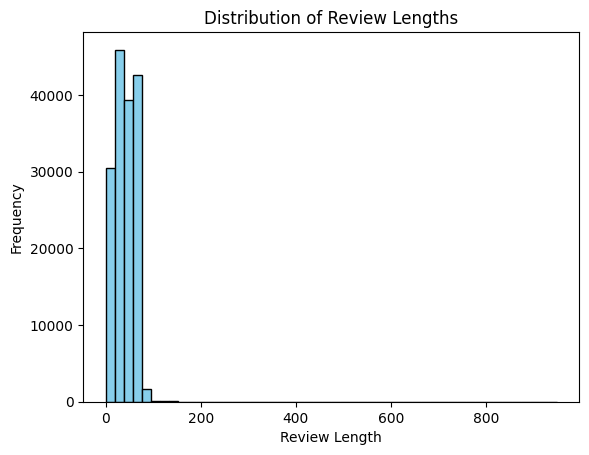

In [28]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [29]:
# 'fixed_review' 열에서 가장 긴 리뷰의 길이를 찾습니다.
max_length = review_lengths.max()

# 가장 긴 리뷰의 길이를 출력합니다.
print("The length of the longest review:", max_length)

The length of the longest review: 949


In [30]:
# 'fixed_review' 열에서 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 리뷰의 길이가 200자 이상인 인덱스를 찾습니다.
long_reviews_index = review_lengths[review_lengths >= 200].index

# 리뷰의 길이가 200자 이상인 리뷰의 개수를 세기
long_reviews_count = (review_lengths >= 200).sum()

# 결과 출력
print("Number of reviews with length >= 200:", long_reviews_count)

# 해당 인덱스를 사용하여 데이터프레임에서 해당 행을 삭제합니다.
drug_data = drug_data.drop(long_reviews_index)

# 삭제 후의 데이터프레임 정보 출력
print("Number of rows after removing long reviews:", len(drug_data))

Number of reviews with length >= 200: 51
Number of rows after removing long reviews: 160347


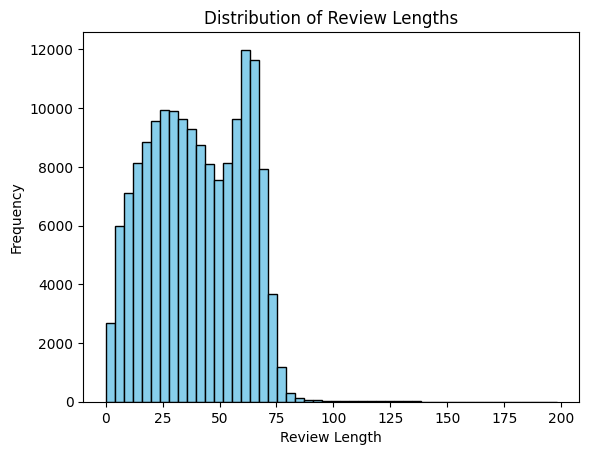

In [31]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)


# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [32]:
# 'fixed_review' 열에서 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 리뷰의 길이가 100자 이상인 리뷰의 개수를 세기
long_reviews_count = (review_lengths >= 100).sum()

# 전체 리뷰의 개수
total_reviews_count = len(drug_data)

# 결과 출력
print("Number of reviews with length >= 200:", long_reviews_count)
print("Total number of reviews:", total_reviews_count)

Number of reviews with length >= 200: 183
Total number of reviews: 160347


In [33]:
# 리뷰의 길이가 100 이상인 인덱스를 찾습니다.
long_reviews_index = review_lengths[review_lengths >= 100].index

# 해당 인덱스를 사용하여 데이터프레임에서 해당 행을 삭제합니다.
drug_data = drug_data.drop(long_reviews_index)

# 삭제 후의 데이터프레임 정보 출력
print("Number of rows after removing long reviews:", len(drug_data))

Number of rows after removing long reviews: 160164


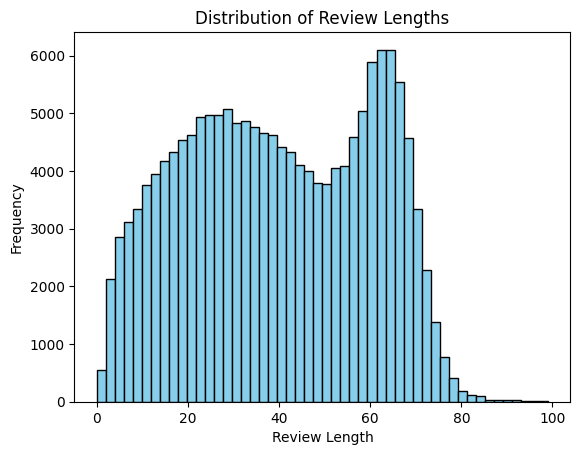

In [34]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

#### 'review' 컬럼 Padding 적용

In [35]:
#drug_data['fixed_review'] = convert_padding(drug_data, 'fixed_review')

In [36]:
#drug_data.head()

In [37]:
#print(drug_data['fixed_review'][0])
#print(len(drug_data['fixed_review'][0]))

#### 'review' 컬럼 Embedding 적용

In [38]:
#drug_data['fixed_review'] = convert_embedding(drug_data, 'fixed_review')

In [39]:
#drug_data.head()

### 'condition', 'drugName' 이상치 처리

In [40]:
drug_data = drug_data[~drug_data['condition'].str.match('\d{2}-[a-zA-Z]{3}-\d{2}', na=False)]
drug_data = drug_data[~drug_data['drugName'].str.match('\d+', na=False)]

### 'condition' 전처리

#### 'condition' 전처리 통합 함수

In [41]:
def preprocess_condition(text):
    fixed_text = del_html(text) # html 코드 제거
    #fixed_text = del_space(fixed_text) # 공백 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(fixed_text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    tokens = fix_tokenize(fixed_text) # 토큰화
    fixed_text = join_tokens(tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

#### 'condition' 전처리 통합 함수 적용

In [42]:
drug_data['fixed_condition'] = drug_data['condition'].apply(preprocess_condition)

In [43]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunction]"
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd]
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]"
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]"
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiate, dependence]"


#### 'condition' 컬럼 Stemming 적용

In [44]:
drug_data['fixed_condition'] = drug_data['fixed_condition'].apply(porter_stemming)

In [45]:
print("stemming result length : ", len(set(word for review in drug_data['fixed_condition'] for word in review)))

stemming result length :  975


#### 'condition' 컬럼 Padding 적용

In [46]:
#drug_data['fixed_condition'] = convert_padding(drug_data, 'fixed_condition')

In [47]:
#drug_data.head()

#### 'condition' 컬럼 Embedding 적용

In [48]:
#drug_data['fixed_condition'] = convert_embedding(drug_data, 'fixed_condition')

In [49]:
#drug_data.head()

### 'Combined_re_con' 생성

#### fixed_condition'와 'fixed_review' 컬럼이 모두 비어 있는 리스트 행 개수

In [50]:
#empty_both_rows = (drug_data['fixed_condition'].apply(len) == 0) & (drug_data['fixed_review'].apply(len) == 0)
#empty_both_count = empty_both_rows.sum()

#print("Counts of 'fixed_condition', 'fixed_review' is Empty :", empty_both_count)

#### fixed_condition'와 'fixed_review' 컬럼이 모두 비어 있는 리스트 행 제거

In [51]:
#print("Before Delete Dataset Size :", drug_data.shape)

#drug_data = drug_data[~((drug_data['fixed_condition'].apply(len) == 0) & (drug_data['fixed_review'].apply(len) == 0))]

#print("After Delete Dataset Size  :", drug_data.shape)

In [52]:
#drug_data.head()

#### 'fixed_review' , 'fixed_condition' 결합

In [53]:
drug_data['Combined_re_con'] = drug_data['fixed_review'] + drug_data['fixed_condition']

In [54]:
drug_data['Combined_re_con'].head()

0    [no, side, effect, take, combin, bystol, fish,...
1    [son, halfway, fourth, week, intuniv, becam, c...
2    [use, take, anoth, oral, contracept, cycl, hap...
3    [first, time, use, form, birth, control, glad,...
4    [suboxon, complet, turn, life, around, feel, h...
Name: Combined_re_con, dtype: object

In [55]:
max_length = drug_data['Combined_re_con'].apply(len).max()

print("Max length:", max_length)

Max length: 101


#### 'Combined_re_con' 컬럼 등장 빈도 3회 미만 단어

In [56]:
from collections import Counter

words = []
for text in drug_data['Combined_re_con']:
    words.extend(text)

word_freq = Counter(words)

words_to_remove = {word for word, freq in word_freq.items() if freq < 3} # 등장 빈도 3회 미만 단어

print("총 단어:", len(set(words)))

print("등장 빈도가 3회 미만인 단어 :", len(words_to_remove))

총 단어: 32647
등장 빈도가 3회 미만인 단어 : 16568


#### 'Combined_re_con' 등장 빈도 3회 미만 단어 제거

In [57]:
drug_data['Combined_re_con'] = drug_data['Combined_re_con'].apply(
    lambda text_list: [word for word in text_list if word not in words_to_remove]
)

words = []
for text in drug_data['Combined_re_con']: # 제거 후 총 단어 개수 
    words.extend(text)

print("총 단어:", len(set(words)))

총 단어: 16079


In [58]:
drug_data['Combined_re_con'].isnull().sum()

0

In [59]:
drug_data['Combined_re_con'].head()

0    [no, side, effect, take, combin, bystol, fish,...
1    [son, halfway, fourth, week, intuniv, becam, c...
2    [use, take, anoth, oral, contracept, cycl, hap...
3    [first, time, use, form, birth, control, glad,...
4    [suboxon, complet, turn, life, around, feel, h...
Name: Combined_re_con, dtype: object

#### 'Combined_re_con' Padding 적용

In [60]:
type(drug_data['Combined_re_con'])

pandas.core.series.Series

In [61]:
drug_data['Padding_re_con'] = convert_padding(drug_data, 'Combined_re_con')

In [62]:
print("MAX :", max([max(row) for row in drug_data['Padding_re_con']]))

MAX : 16079


#### 'Combined_re_con' Embedding 적용

In [63]:
#drug_data['Embedding_re_con'] = convert_embedding(drug_data, 'Padding_re_con')

In [64]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1..."


### 'drugName' 인코딩

#### 'drugName' Label Encoding

In [65]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 초기화
label_encoder = LabelEncoder()

drug_data['encoded_drugName'] = label_encoder.fit_transform(drug_data['drugName'])

print(drug_data[['drugName', 'encoded_drugName']])

                        drugName  encoded_drugName
0                      Valsartan              3197
1                     Guanfacine              1428
2                         Lybrel              1851
3                     Ortho Evra              2279
4       Buprenorphine / naloxone               515
...                          ...               ...
161292                   Campral               554
161293            Metoclopramide              1971
161294                   Orencia              2273
161295        Thyroid desiccated              3022
161296              Lubiprostone              1837

[160164 rows x 2 columns]


#### 'drugName' Label Encoding MAX number

In [66]:
print("MAX Number :", drug_data['encoded_drugName'].max())

MAX Number : 3429


### 'fixed_date' 생성

#### 'date' 컬럼 'datetime' 형식으로 변환

In [67]:
drug_data['fixed_date'] = pd.to_datetime(drug_data['date'])

/tmp/ipykernel_358656/4049783553.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  drug_data['fixed_date'] = pd.to_datetime(drug_data['date'])


In [68]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName,fixed_date
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,2012-05-20
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,2010-04-27
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2009-12-14
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,2015-11-03
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,2016-11-27


## 모델링에 불필요한 컬럼 제거 후 새로운 데이터 프레임 생성

In [69]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName,fixed_date
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,2012-05-20
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,2010-04-27
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2009-12-14
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,2015-11-03
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,2016-11-27


### 전처리가 끝난 데이터셋 백업

In [70]:
drug_data_after_preprocess = drug_data

In [71]:
#drug_data_after_preprocess.to_csv('drug_data_after_preprocess.csv', index=True)

### 모델링을 위한 불필요한 컬럼 제거

In [72]:
#drug_data_for_modeling = drug_data.drop(columns=['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'sentiment', 'fixed_date'])
drug_data_for_modeling = drug_data[['Combined_re_con', 'encoded_drugName']].copy()

### 모델링을 위한 불필요한 컬럼이 제거된 데이터셋 백업

In [73]:
drug_data_for_modeling.to_csv('drug_data_for_modeling.csv', index=False)

In [74]:
drug_data_for_modeling.head()

,Combined_re_con,encoded_drugName
0,"[no, side, effect, take, combin, bystol, fish,...",3197
1,"[son, halfway, fourth, week, intuniv, becam, c...",1428
2,"[use, take, anoth, oral, contracept, cycl, hap...",1851
3,"[first, time, use, form, birth, control, glad,...",2279
4,"[suboxon, complet, turn, life, around, feel, h...",515


In [75]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences

#X_embedded = []
#for sentence in drug_data_for_modeling['Combined_re_con']:
#    embedded_sentence = convert_embedding(sentence)
#    X_embedded.append(embedded_sentence)

#MAX_SEQUENCE_LENGTH = max(len(seq) for seq in X_embedded)
#X_padded = pad_sequences(X_embedded, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

#print("패딩된 시퀀스의 크기:", X_padded.shape)

In [76]:
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense

#EMBEDDING_DIM = 50
#NUM_CLASSES = drug_data_for_modeling['encoded_drugName'].nunique()

#X = X_padded
#y = drug_data_for_modeling['encoded_drugName']

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#model = Sequential([
#    LSTM(64, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)), 
#    Dense(NUM_CLASSES, activation='softmax')
#])

#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#loss, accuracy = model.evaluate(X_val, y_val)

In [77]:
drug_data_for_tpot = drug_data[['Padding_re_con', 'encoded_drugName']].copy()

In [78]:
drug_data_for_tpot.to_csv('data/drug_data_for_tpot.csv', index=False)

In [79]:
drug_data_for_tpot.head()

,Padding_re_con,encoded_drugName
0,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197
1,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428
2,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851
3,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279
4,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515


## 가중치

In [80]:
drug_data_for_weight = drug_data.drop(columns=['uniqueID', 'drugName', 'condition', 'review', 'date', 'fixed_review', 'fixed_condition', 'Combined_re_con', 'fixed_date'])

### 파생변수 'sentiment' 생성

In [81]:
drug_data_for_weight.head()

,rating,usefulCount,Padding_re_con,encoded_drugName
0,9,27,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197
1,8,192,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428
2,5,17,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851
3,8,10,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279
4,9,37,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515


#### rating(평점)이 8 이상이면 3(긍정), 5이상 7이하이면 2(보통), 1이상 4이하이면 1(부정)

In [82]:
drug_data_for_weight['sentiment'] = drug_data_for_weight['rating'].apply(lambda x: 3 if x >= 8 else (2 if x >= 5 else 1))

In [83]:
drug_data_for_weight.head()

,rating,usefulCount,Padding_re_con,encoded_drugName,sentiment
0,9,27,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,3
1,8,192,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,3
2,5,17,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2
3,8,10,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,3
4,9,37,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,3


####

### 파생변수 'uC_rank' 생성

최대 usefulCount : 1291


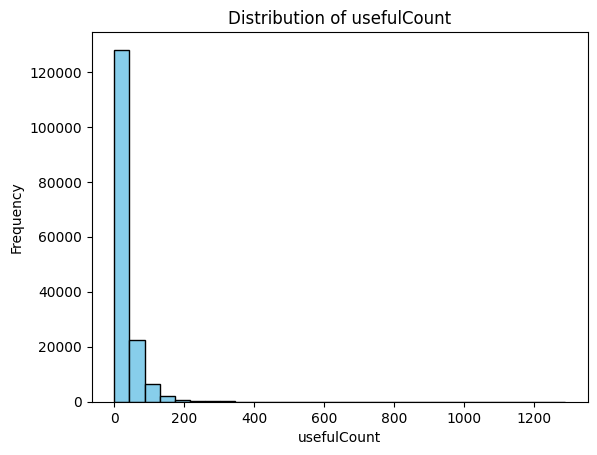

In [84]:
import matplotlib.pyplot as plt

max_value = max(drug_data_for_weight['usefulCount'])
print("최대 usefulCount :", max_value)

plt.hist(drug_data_for_weight['usefulCount'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('usefulCount')
plt.ylabel('Frequency')
plt.title('Distribution of usefulCount')
plt.show()

#### 'usefulCount' 값이 300 초과인 행 제거

In [85]:
drug_data_for_weight.shape

(160164, 5)

In [86]:
drug_data_for_weight = drug_data_for_weight[drug_data['usefulCount'] <= 300]

In [87]:
drug_data_for_weight.shape

(159958, 5)

최대 usefulCount : 1291


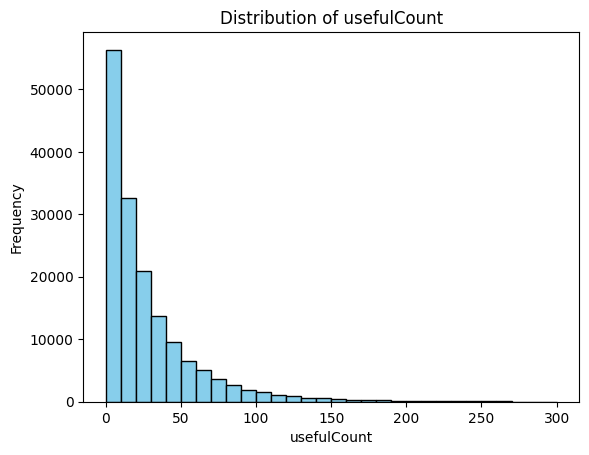

In [88]:
import matplotlib.pyplot as plt

max_value = max(drug_data['usefulCount'])
print("최대 usefulCount :", max_value)

plt.hist(drug_data_for_weight['usefulCount'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('usefulCount')
plt.ylabel('Frequency')
plt.title('Distribution of usefulCount')
plt.show()

In [89]:
drug_data_for_weight['usefulCount'].describe()

count    159958.000000
mean         27.574720
std          33.201179
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max         300.000000
Name: usefulCount, dtype: float64

#### 1(50% 이하), 2(평균 이하), 3(75% 이하), 4(50이하), 5(50이상)

In [90]:
def rank_useful_count(value):
    if value <= 16:
        return 1
    elif value <= 28:
        return 2
    elif value <= 36:
        return 3
    elif value <= 50:
        return 4
    else:
        return 5  

drug_data_for_weight['uC_rank'] = drug_data_for_weight['usefulCount'].apply(rank_useful_count)

In [91]:
drug_data_for_weight.head()

,rating,usefulCount,Padding_re_con,encoded_drugName,sentiment,uC_rank
0,9,27,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,3,2
1,8,192,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,3,5
2,5,17,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2,2
3,8,10,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,3,1
4,9,37,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,3,4


### 데이터셋 백업

In [92]:
drug_data_pp_weight = drug_data_for_weight.drop(columns=['rating', 'usefulCount'])
#drug_data_pp_weight = drug_data_for_weight.drop(columns=['sentiment', 'uC_rank'])

In [93]:
drug_data_pp_weight.head()

,Padding_re_con,encoded_drugName,sentiment,uC_rank
0,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,3,2
1,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,3,5
2,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2,2
3,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,3,1
4,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,3,4


In [94]:
drug_data_pp_weight.to_csv('data/drug_data_pp_weight.csv', index=False)

In [95]:
drug_data_for_weight.shape

(159958, 6)

In [96]:
indices_to_remove = drug_data_for_weight[drug_data_for_weight['usefulCount'] < 10].index
drug_data_for_weight.drop(indices_to_remove, inplace=True)
print("Number of rows removed:", len(indices_to_remove))

Number of rows removed: 56341


In [97]:
drug_data_for_weight.shape

(103617, 6)

In [98]:
indices_to_remove = drug_data_for_weight[drug_data_for_weight['rating'] <= 8].index
drug_data_for_weight.drop(indices_to_remove, inplace=True)
# 삭제된 행의 개수를 출력합니다.
print("Number of rows removed:", len(indices_to_remove))

Number of rows removed: 45646


In [99]:
drug_data_for_weight.shape

(57971, 6)

In [100]:
drug_data_for_weight.to_csv('data/drug_data_positive.csv', index=False)

#### drugName 상위 10개, 30개, 50개, 100개

In [101]:
drug_data_Top = drug_data.drop(columns=['uniqueID', 'condition', 'review', 'date', 'fixed_review', 'fixed_condition', 'Combined_re_con', 'fixed_date'])

In [102]:
drug_data_Top.head()

,drugName,rating,usefulCount,Padding_re_con,encoded_drugName
0,Valsartan,9,27,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197
1,Guanfacine,8,192,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428
2,Lybrel,5,17,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851
3,Ortho Evra,8,10,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279
4,Buprenorphine / naloxone,9,37,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515


In [103]:
drug_data_Top = drug_data_Top[drug_data_Top['usefulCount'] <= 300]

In [104]:
drug_data_Top['sentiment'] = drug_data_Top['rating'].apply(lambda x: 3 if x >= 8 else (2 if x >= 5 else 1))

In [105]:
drug_data_Top['uC_rank'] = drug_data_Top['usefulCount'].apply(rank_useful_count)

In [106]:
drug_data_Top.head()

,drugName,rating,usefulCount,Padding_re_con,encoded_drugName,sentiment,uC_rank
0,Valsartan,9,27,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,3,2
1,Guanfacine,8,192,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,3,5
2,Lybrel,5,17,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2,2
3,Ortho Evra,8,10,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,3,1
4,Buprenorphine / naloxone,9,37,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,3,4


In [107]:
# 'drugName' 열에서 각 값의 등장 빈도를 세기
drug_name_counts = drug_data_Top['drugName'].value_counts()

# 등장 빈도를 기준으로 내림차순 정렬
sorted_counts = drug_name_counts.sort_values(ascending=False)

# 등장 빈도 순위 출력
for rank, (drug_name, count) in enumerate(sorted_counts.items(), start=1):
    print(f"Rank {rank}: {drug_name} - {count} occurrences")

Rank 1: Levonorgestrel - 3611 occurrences
Rank 2: Etonogestrel - 3316 occurrences
Rank 3: Ethinyl estradiol / norethindrone - 2744 occurrences
Rank 4: Nexplanon - 2155 occurrences
Rank 5: Ethinyl estradiol / norgestimate - 2033 occurrences
Rank 6: Ethinyl estradiol / levonorgestrel - 1806 occurrences
Rank 7: Phentermine - 1529 occurrences
Rank 8: Sertraline - 1341 occurrences
Rank 9: Escitalopram - 1282 occurrences
Rank 10: Mirena - 1232 occurrences
Rank 11: Implanon - 1099 occurrences
Rank 12: Gabapentin - 1039 occurrences
Rank 13: Bupropion - 1011 occurrences
Rank 14: Venlafaxine - 1007 occurrences
Rank 15: Miconazole - 997 occurrences
Rank 16: Citalopram - 983 occurrences
Rank 17: Medroxyprogesterone - 970 occurrences
Rank 18: Lexapro - 946 occurrences
Rank 19: Bupropion / naltrexone - 945 occurrences
Rank 20: Duloxetine - 927 occurrences
Rank 21: Contrave - 920 occurrences
Rank 22: Metronidazole - 918 occurrences
Rank 23: Depo-Provera - 881 occurrences
Rank 24: Cymbalta - 861 occur

In [108]:
# 1위부터 3위까지의 drugName을 추출
top_3_drugNames = sorted_counts.head(3).index

# 1위부터 10위까지의 drugName을 추출
top_10_drugNames = sorted_counts.head(10).index

# 1위부터 30위까지의 drugName을 추출
top_30_drugNames = sorted_counts.head(30).index

# 1위부터 50위까지의 drugName을 추출
top_50_drugNames = sorted_counts.head(50).index

# 1위부터 100위까지의 drugName을 추출
top_100_drugNames = sorted_counts.head(100).index

# drugName이 top_3_drugNames에 있는 행만 추출하여 새로운 데이터프레임 생성
drug_data_drugTop3 = drug_data_Top[drug_data_Top['drugName'].isin(top_3_drugNames)].copy()

# drugName이 top_10_drugNames에 있는 행만 추출하여 새로운 데이터프레임 생성
drug_data_drugTop10 = drug_data_Top[drug_data_Top['drugName'].isin(top_10_drugNames)].copy()

# drugName이 top_30_drugNames에 있는 행만 추출하여 새로운 데이터프레임 생성
drug_data_drugTop30 = drug_data_Top[drug_data_Top['drugName'].isin(top_30_drugNames)].copy()

# drugName이 top_50_drugNames에 있는 행만 추출하여 새로운 데이터프레임 생성
drug_data_drugTop50 = drug_data_Top[drug_data_Top['drugName'].isin(top_50_drugNames)].copy()

# drugName이 top_100_drugNames에 있는 행만 추출하여 새로운 데이터프레임 생성
drug_data_drugTop100 = drug_data_Top[drug_data_Top['drugName'].isin(top_100_drugNames)].copy()

In [109]:
print(drug_data_drugTop3.shape)
print(drug_data_drugTop10.shape)
print(drug_data_drugTop30.shape)
print(drug_data_drugTop50.shape)
print(drug_data_drugTop100.shape)

(9671, 7)
(21049, 7)
(39482, 7)
(52508, 7)
(75342, 7)


In [110]:
drug_data_drugTop3 = drug_data_drugTop3.drop(columns=['drugName', 'rating', 'usefulCount'])
drug_data_drugTop10 = drug_data_drugTop10.drop(columns=['drugName', 'rating', 'usefulCount'])
drug_data_drugTop30 = drug_data_drugTop30.drop(columns=['drugName', 'rating', 'usefulCount'])
drug_data_drugTop50 = drug_data_drugTop50.drop(columns=['drugName', 'rating', 'usefulCount'])
drug_data_drugTop100 = drug_data_drugTop100.drop(columns=['drugName', 'rating', 'usefulCount'])

In [111]:
drug_data_drugTop3.to_csv('data/drug_data_drugTop3_label.csv', index=False)
drug_data_drugTop10.to_csv('data/drug_data_drugTop10_label.csv', index=False)
drug_data_drugTop30.to_csv('data/drug_data_drugTop30_label.csv', index=False)
drug_data_drugTop50.to_csv('data/drug_data_drugTop50_label.csv', index=False)
drug_data_drugTop100.to_csv('data/drug_data_drugTop100_label.csv', index=False)

### 타겟 변수 원-핫 인코딩

In [112]:
drug_data_drugTop100_onehot = drug_data_Top[drug_data_Top['drugName'].isin(top_100_drugNames)].copy()
drug_data_drugTop50_onehot = drug_data_Top[drug_data_Top['drugName'].isin(top_50_drugNames)].copy()
drug_data_drugTop30_onehot = drug_data_Top[drug_data_Top['drugName'].isin(top_30_drugNames)].copy()
drug_data_drugTop10_onehot = drug_data_Top[drug_data_Top['drugName'].isin(top_10_drugNames)].copy()
drug_data_drugTop3_onehot = drug_data_Top[drug_data_Top['drugName'].isin(top_3_drugNames)].copy()

In [113]:
drug_data_drugTop3_onehot.head()

,drugName,rating,usefulCount,Padding_re_con,encoded_drugName,sentiment,uC_rank
6,Levonorgestrel,1,5,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1745,1,1
22,Etonogestrel,9,11,"[375, 338, 238, 280, 106, 65, 20, 227, 190, 22...",1186,3,1
74,Etonogestrel,10,1,"[96, 61, 2, 320, 331, 152, 102, 44, 70, 8, 20,...",1186,3,1
83,Levonorgestrel,1,10,"[345, 74, 76, 26, 66, 135, 2315, 136, 7, 63, 2...",1745,1,1
113,Levonorgestrel,10,1,"[13, 568, 263, 2315, 1249, 568, 891, 39, 441, ...",1745,3,1


In [114]:
drug_data_drugTop100_onehot = drug_data_drugTop100_onehot.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])
drug_data_drugTop50_onehot = drug_data_drugTop50_onehot.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])
drug_data_drugTop30_onehot = drug_data_drugTop30_onehot.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])
drug_data_drugTop10_onehot = drug_data_drugTop10_onehot.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])
drug_data_drugTop3_onehot = drug_data_drugTop3_onehot.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])

In [115]:
drug_data_drugTop100_onehot.head()

,drugName,Padding_re_con,sentiment,uC_rank
4,Buprenorphine / naloxone,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",3,4
6,Levonorgestrel,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1,1
7,Aripiprazole,"[807, 77, 37, 92, 356, 1797, 15, 9, 807, 433, ...",3,3
9,Ethinyl estradiol / levonorgestrel,"[21, 133, 26, 32, 77, 1392, 2755, 4, 43, 24, 1...",3,1
10,Topiramate,"[29, 76, 52, 19, 9, 6, 154, 422, 7, 72, 97, 16...",3,2


In [116]:
drug_data_drugTop3_onehot.shape

(9671, 4)

In [117]:
drug_data_drugTop100_onehot.head()

,drugName,Padding_re_con,sentiment,uC_rank
4,Buprenorphine / naloxone,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",3,4
6,Levonorgestrel,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1,1
7,Aripiprazole,"[807, 77, 37, 92, 356, 1797, 15, 9, 807, 433, ...",3,3
9,Ethinyl estradiol / levonorgestrel,"[21, 133, 26, 32, 77, 1392, 2755, 4, 43, 24, 1...",3,1
10,Topiramate,"[29, 76, 52, 19, 9, 6, 154, 422, 7, 72, 97, 16...",3,2


In [118]:
#print(drug_data_drugTop100_onehot.shape)
print(drug_data_drugTop50_onehot.shape)
print(drug_data_drugTop30_onehot.shape)
print(drug_data_drugTop10_onehot.shape)
print(drug_data_drugTop3_onehot.shape)

(52508, 4)
(39482, 4)
(21049, 4)
(9671, 4)


In [119]:
drug_data_drugTop100_onehot = pd.get_dummies(drug_data_drugTop100_onehot, columns=['drugName'], prefix='', prefix_sep='')
drug_data_drugTop50_onehot = pd.get_dummies(drug_data_drugTop50_onehot, columns=['drugName'], prefix='', prefix_sep='')
drug_data_drugTop30_onehot = pd.get_dummies(drug_data_drugTop30_onehot, columns=['drugName'], prefix='', prefix_sep='')
drug_data_drugTop10_onehot = pd.get_dummies(drug_data_drugTop10_onehot, columns=['drugName'], prefix='', prefix_sep='')
drug_data_drugTop3_onehot = pd.get_dummies(drug_data_drugTop3_onehot, columns=['drugName'], prefix='', prefix_sep='')

In [120]:
drug_data_drugTop3_onehot.head()

,Padding_re_con,sentiment,uC_rank,Ethinyl estradiol / norethindrone,Etonogestrel,Levonorgestrel
6,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1,1,False,False,True
22,"[375, 338, 238, 280, 106, 65, 20, 227, 190, 22...",3,1,False,True,False
74,"[96, 61, 2, 320, 331, 152, 102, 44, 70, 8, 20,...",3,1,False,True,False
83,"[345, 74, 76, 26, 66, 135, 2315, 136, 7, 63, 2...",1,1,False,False,True
113,"[13, 568, 263, 2315, 1249, 568, 891, 39, 441, ...",3,1,False,False,True


In [121]:
print(drug_data_drugTop100_onehot.shape)
print(drug_data_drugTop50_onehot.shape)
print(drug_data_drugTop30_onehot.shape)
print(drug_data_drugTop10_onehot.shape)
print(drug_data_drugTop3_onehot.shape)

(75342, 103)
(52508, 53)
(39482, 33)
(21049, 13)
(9671, 6)


In [122]:
drug_data_drugTop3_onehot.to_csv('data/drug_data_drugTop3_onehot.csv', index=False)
drug_data_drugTop10_onehot.to_csv('data/drug_data_drugTop10_onehot.csv', index=False)
drug_data_drugTop30_onehot.to_csv('data/drug_data_drugTop30_onehot.csv', index=False)
drug_data_drugTop50_onehot.to_csv('data/drug_data_drugTop50_onehot.csv', index=False)
drug_data_drugTop100_onehot.to_csv('data/drug_data_drugTop100_onehot.csv', index=False)

### drugName 카테고리 분류

In [133]:
drug_data_Top100 = drug_data_Top[drug_data_Top['drugName'].isin(top_100_drugNames)].copy()

In [134]:
drug_data_Top100 = drug_data_Top100.drop(columns=['rating', 'usefulCount', 'encoded_drugName'])

In [135]:
drug_data_Top100.shape

(75342, 4)

In [136]:
drug_data_Top100.head()

,drugName,Padding_re_con,sentiment,uC_rank
4,Buprenorphine / naloxone,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",3,4
6,Levonorgestrel,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1,1
7,Aripiprazole,"[807, 77, 37, 92, 356, 1797, 15, 9, 807, 433, ...",3,3
9,Ethinyl estradiol / levonorgestrel,"[21, 133, 26, 32, 77, 1392, 2755, 4, 43, 24, 1...",3,1
10,Topiramate,"[29, 76, 52, 19, 9, 6, 154, 422, 7, 72, 97, 16...",3,2


In [128]:
top_100_drugNames

Index(['Levonorgestrel', 'Etonogestrel', 'Ethinyl estradiol / norethindrone',
       'Nexplanon', 'Ethinyl estradiol / norgestimate',
       'Ethinyl estradiol / levonorgestrel', 'Phentermine', 'Sertraline',
       'Escitalopram', 'Mirena', 'Implanon', 'Gabapentin', 'Bupropion',
       'Venlafaxine', 'Miconazole', 'Citalopram', 'Medroxyprogesterone',
       'Lexapro', 'Bupropion / naltrexone', 'Duloxetine', 'Contrave',
       'Metronidazole', 'Depo-Provera', 'Cymbalta',
       'Drospirenone / ethinyl estradiol', 'Clonazepam', 'Quetiapine', 'Skyla',
       'Tramadol', 'Zoloft', 'Varenicline', 'Fluoxetine', 'Liraglutide',
       'Tioconazole', 'Alprazolam', 'Amitriptyline', 'Lo Loestrin Fe',
       'Paroxetine', 'Chantix', 'Ethinyl estradiol / etonogestrel',
       'Doxycycline', 'Magnesium sulfate / potassium sulfate / sodium sulfate',
       'NuvaRing', 'Pregabalin', 'Copper', 'Plan B', 'Topiramate',
       'Suprep Bowel Prep Kit', 'Lamotrigine', 'Trazodone', 'Desvenlafaxine',
       '

#### 각 분류에 해당하는 drugName

피임약 (Contraceptives) : 
Levonorgestrel
Etonogestrel
Ethinyl estradiol / norethindrone
Nexplanon
Ethinyl estradiol / norgestimate
Ethinyl estradiol / levonorgestrel
Mirena
Implanon
Depo-Provera
Drospirenone / ethinyl estradiol
Skyla
NuvaRing
Copper
Plan B
Lo Loestrin Fe
Sprintec
Desogestrel / ethinyl estradiol
Loestrin 24 Fe
Plan B One-Step
Microgestin Fe 1 / 20
Tri-Sprintec
Ethinyl estradiol / norelgestromin
ParaGard

항우울제 (Antidepressants) : 
Sertraline
Escitalopram
Bupropion
Duloxetine
Citalopram
Lexapro
Paroxetine
Desvenlafaxine
Fluoxetine
Venlafaxine
Mirtazapine

체중 감량 약 (Weight Loss Medications) : 
Phentermine
Contrave
Lorcaserin

항진정제/불안 치료제 (Anxiolytics / Anti-anxiety Medications) : 
Clonazepam
Alprazolam
Buspirone

뇌신경작용제/주의력결핍 과잉행동장애(ADHD) 치료제 (Psychostimulants for ADHD) : 
Lisdexamfetamine
Methylphenidate
Amphetamine / dextroamphetamine
Vyvanse

담배 부담 줄이는 약물 (Smoking Cessation Aids)
Varenicline
Chantix

조울증 및 양극성 장애 치료제 (Mood Stabilizers and Treatments for Bipolar Disorder) : 
Quetiapine
Aripiprazole

수면 보조제 (Sleep Aids) : 
Zolpidem
Trazodone

진통제 (Analgesics) : 
Tramadol
Oxycodone
Acetaminophen / hydrocodone

항생제 (Antibiotics) : 
Metronidazole
Doxycycline
Azithromycin
Ciprofloxacin
Nitrofurantoin
Clindamycin

In [ ]:
# 약물 카테고리 리스트들
drug_categories = {
    'contraceptives': ['Levonorgestrel', 'Etonogestrel', 'Ethinyl estradiol / norethindrone', 'Nexplanon',
                       'Ethinyl estradiol / norgestimate', 'Ethinyl estradiol / levonorgestrel', 'Mirena', 'Implanon',
                       'Depo-Provera', 'Drospirenone / ethinyl estradiol', 'Skyla', 'NuvaRing', 'Copper', 'Plan B',
                       'Lo Loestrin Fe', 'Sprintec', 'Desogestrel / ethinyl estradiol', 'Loestrin 24 Fe',
                       'Plan B One-Step', 'Microgestin Fe 1 / 20', 'Tri-Sprintec', 'Ethinyl estradiol / norelgestromin',
                       'ParaGard'],
    'antidepressants': ['Sertraline', 'Escitalopram', 'Bupropion', 'Duloxetine', 'Citalopram', 'Lexapro', 'Paroxetine',
                        'Desvenlafaxine', 'Fluoxetine', 'Venlafaxine', 'Mirtazapine'],
    'weight_loss_medications': ['Phentermine', 'Contrave', 'Lorcaserin'],
    'anxiolytics': ['Clonazepam', 'Alprazolam', 'Buspirone'],
    'psychostimulants_for_adhd': ['Lisdexamfetamine', 'Methylphenidate', 'Amphetamine / dextroamphetamine', 'Vyvanse'],
    'smoking_cessation_aids': ['Varenicline', 'Chantix'],
    'mood_stabilizers_bipolar_disorder': ['Quetiapine', 'Aripiprazole'],
    'sleep_aids': ['Zolpidem', 'Trazodone'],
    'analgesics': ['Tramadol', 'Oxycodone', 'Acetaminophen / hydrocodone'],
    'antibiotics': ['Metronidazole', 'Doxycycline', 'Azithromycin', 'Ciprofloxacin', 'Nitrofurantoin', 'Clindamycin']
}

,drugName,Padding_re_con,sentiment,uC_rank,contraceptives,antidepressants,weight_loss_medications,anxiolytics,psychostimulants_for_adhd,smoking_cessation_aids,mood_stabilizers_bipolar_disorder,sleep_aids,analgesics,antibiotics
4,Buprenorphine / naloxone,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",3,4,False,False,False,False,False,False,False,False,False,False
6,Levonorgestrel,"[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1,1,True,False,False,False,False,False,False,False,False,False
7,Aripiprazole,"[807, 77, 37, 92, 356, 1797, 15, 9, 807, 433, ...",3,3,False,False,False,False,False,False,True,False,False,False
9,Ethinyl estradiol / levonorgestrel,"[21, 133, 26, 32, 77, 1392, 2755, 4, 43, 24, 1...",3,1,True,False,False,False,False,False,False,False,False,False
10,Topiramate,"[29, 76, 52, 19, 9, 6, 154, 422, 7, 72, 97, 16...",3,2,False,False,False,False,False,False,False,False,False,False


In [ ]:
drug_data_Top100['drug_category'] = None
for category, drugs in categories.items():
    drug_data_Top100.loc[drug_data_Top100['drugName'].isin(drugs), 'drug_category'] = category